In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
import joblib
from preprocess import pfeature_process
from seq_cleanup import clean_seq
from network import create_model
import csv
import torch
import yaml
import subprocess
from pepfunn.sequence import Sequence

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
seqs = pd.read_csv('../data/processed/generated_seqs.csv')
seqs


,sequences
0,INNTLVLLCNLFNIRYLDFCGYEKHWPYIVDGDFGYGCPRKLIPTT...
1,DENLGSEMERDCLPTDSKFNYECGSKEKQLIKMIKNCVKMNLSGYV...
2,DGAEFCRQAGGEMWSRPAVQSFPGLTTYPRNPTQFAARRNVAYLCR...
3,NIYNSDYRXPWYMEIYCRRGHRLGPRAQTRPAPCCGSTTAGPRVFP...
4,KSTEDLMDEVYKQIVPRECNNKEHXRTRGTPSQSTRVLQLDTQVQD...
...,...
2995,ASNTTVETMYEDDDHHWDREGPQPITRDYILSPPGEETTMSDVLAR...
2996,RHWMIDSWKMGVFIFPAYELNTSSNWFYPLRKQVYYKVRFWEAPNG...
2997,TGPVTQWRFTIVERHDSRKYLTYREDTTKAGTISIPQNWLYSQKQM...
2998,DEINEIEETVRQQEAQTMIVDMDSNEQSNVACGRDDENNLCQILIS...


In [3]:
print(type(seqs))
print(seqs.columns)


<class 'pandas.core.frame.DataFrame'>
Index(['sequences'], dtype='object')


In [4]:
#Clean up seceuences, uppercase, remove invalid chars, remove X from begging and end of sequence
#remove sequences with intermediary Xs
filtered_df = clean_seq(seqs)
filtered_df

,sequences
0,INNTLVLLCNLFNIRYLDFCGYEKHWPYIVDGDFGYGCPRKLIPTT...
1,DENLGSEMERDCLPTDSKFNYECGSKEKQLIKMIKNCVKMNLSGYV...
2,DGAEFCRQAGGEMWSRPAVQSFPGLTTYPRNPTQFAARRNVAYLCR...
3,DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLR...
4,IGRLLRRMMRPIMKTCLNVGYHIPNSMEQKHCWDGLSLGWRNDIRM...
...,...
2380,KEWYKKHYLTTGNLTHDERNLWMNMMWLTEIIEKNENRCDIWEIGDCMV
2381,LSSLPWIMRLNLWTRHDAVQTGEMMNDQKPHWFNIWRHTWLGHKGQCHS
2382,DRYMEYMYGCEMYIENGDIIEMDKEEKSGEKNNFNCCVCYFDGMFWFFL
2383,TRYEIVHDYKNYPLFNDKGIIDCACPHPITSSKKHHHLSINHGQVASYY


In [5]:
#Convert cleaned dataframe to Fasta format
with open('../data/interim/filtered_seqs.fasta','w', encoding='UTF8') as f:
    
    for i in range(len(filtered_df)):
        f.write(f">{i}\n{filtered_df.iloc[i,0]}\n")

In [6]:
cd_hit_path = "../data/interim/filtered_seqs_cd_hit.txt"

In [7]:
# Process sequences with CD-HIT using WSL on windows environment
# Ensure that WSL is installed and CD-HIT is available in the WSL environment
command = ["wsl", "cd-hit", "-i", "../data/interim/filtered_seqs.fasta", "-o", cd_hit_path, "-c", "0.99"]

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

STDOUT: ================================================================
Program: CD-HIT, V4.8.1 (+OpenMP), Aug 20 2021, 08:39:56
Command: cd-hit -i ../data/interim/filtered_seqs.fasta -o
         ../data/interim/filtered_seqs_cd_hit.txt -c 0.99

Started: Thu Jun 26 17:13:47 2025
                            Output                              
----------------------------------------------------------------
total seq: 2384
longest and shortest : 50 and 13
Total letters: 119033
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 76M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 90456802


comparing sequences from          0  to       2384
..
     2384  finished       2384  clusters

Approximated maximum memory consumption: 77M
writing new database
writing clustering information

In [8]:
processed_seqs = pfeature_process(cd_hit_path,'../data/processed/pre_processed_seqs_pfeature.csv')
processed_seqs

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
INNTLVLLCNLFNIRYLDFCGYEKHWPYIVDGDFGYGCPRKLIPTTHAQQ,-0.367806,-0.529793,0.682087,-0.096100,0.351349,1.085093,0.276332,0.269456,-0.529793,-0.367806,...,-1.928448,1.402550,0.057124,2.446951,0.070890,-2.964259,1.901900,0.006922,0.340905,0.019330
DENLGSEMERDCLPTDSKFNYECGSKEKQLIKMIKNCVKMNLSGYVIITD,-0.036907,1.423120,-0.976164,-0.096100,-1.027935,-0.475749,-0.919646,-1.405773,1.423120,-0.036907,...,0.256098,-0.087809,0.057124,0.245469,0.070890,-0.078852,-0.112187,0.006922,-1.724188,0.019330
DGAEFCRQAGGEMWSRPAVQSFPGLTTYPRNPTQFAARRNVAYLCRKYPE,-0.036907,-0.529793,0.405711,0.208537,0.351349,0.824952,1.472310,-0.065590,-0.529793,-0.036907,...,0.256098,-0.087809,0.057124,0.245469,0.884942,-0.078852,1.901900,0.006922,0.340905,0.019330
DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLRWYIN,1.948488,-0.139211,-1.528914,-1.619285,-0.108412,-0.215609,-0.919646,0.269456,-0.139211,1.948488,...,0.256098,-0.087809,0.057124,-1.956013,0.070890,-0.078852,-0.112187,0.006922,0.340905,0.019330
IGRLLRRMMRPIMKTCLNVGYHIPNSMEQKHCWDGLSLGWRNDIRMIFVD,0.955790,-0.529793,-0.423414,-1.619285,0.811110,0.564812,-0.321657,-1.070727,-0.529793,0.955790,...,1.129916,-0.087809,0.057124,0.245469,0.884942,-0.078852,-0.112187,0.006922,0.340905,0.019330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEWYKKHYLTTGNLTHDERNLWMNMMWLTEIIEKNENRCDIWEIGDCMV,0.343627,1.501237,-1.349271,-1.268952,-0.706102,-1.204142,-1.517635,-0.367131,1.501237,0.343627,...,1.348371,-0.087809,-2.397965,-1.956013,0.070890,-2.964259,1.390863,0.006922,0.340905,0.019330
LSSLPWIMRLNLWTRHDAVQTGEMMNDQKPHWFNIWRHTWLGHKGQCHS,1.021970,-0.900847,-0.216133,-0.644446,0.224915,-0.397707,-0.291758,-0.367131,-0.900847,1.021970,...,1.719743,-0.087809,0.057124,0.245469,0.070890,1.854370,-0.112187,0.006922,0.340905,-2.584266
DRYMEYMYGCEMYIENGDIIEMDKEEKSGEKNNFNCCVCYFDGMFWFFL,-0.996514,2.282402,-0.782702,-0.644446,-0.476221,-1.724423,-1.517635,1.341603,2.282402,-0.996514,...,0.256098,1.402550,-2.397965,-1.956013,0.070890,-0.078852,-3.118286,0.006922,0.340905,0.019330
TRYEIVHDYKNYPLFNDKGIIDCACPHPITSSKKHHHLSINHGQVASYY,1.352869,-0.490735,-0.782702,0.604565,-1.177357,0.135581,0.306231,-0.367131,-0.490735,1.352869,...,-1.928448,-0.087809,0.057124,0.245469,0.070890,1.363851,-0.112187,0.006922,-1.724188,1.060769


In [14]:
#ubicacion de los archivos de datos con el modelo y el archivo FASTA procesado con CD-HIT
model_path = '../models/dtr_model.pkl'
pre_processed_seqs_path = '../data/processed/pre_processed_seqs_pfeature.csv'
positive_seqs_path = '../data/processed/positve_sequences.csv'
pre_processed_seqs = pd.read_csv(pre_processed_seqs_path, index_col=0)
pre_processed_seqs

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
Sequence,,,,,,,,,,,,,,,,,,,,,
INNTLVLLCNLFNIRYLDFCGYEKHWPYIVDGDFGYGCPRKLIPTTHAQQ,-0.367806,-0.529793,0.682087,-0.096100,0.351349,1.085093,0.276332,0.269456,-0.529793,-0.367806,...,-1.928448,1.402550,0.057124,2.446951,0.070890,-2.964259,1.901900,0.006922,0.340905,0.019330
DENLGSEMERDCLPTDSKFNYECGSKEKQLIKMIKNCVKMNLSGYVIITD,-0.036907,1.423120,-0.976164,-0.096100,-1.027935,-0.475749,-0.919646,-1.405773,1.423120,-0.036907,...,0.256098,-0.087809,0.057124,0.245469,0.070890,-0.078852,-0.112187,0.006922,-1.724188,0.019330
DGAEFCRQAGGEMWSRPAVQSFPGLTTYPRNPTQFAARRNVAYLCRKYPE,-0.036907,-0.529793,0.405711,0.208537,0.351349,0.824952,1.472310,-0.065590,-0.529793,-0.036907,...,0.256098,-0.087809,0.057124,0.245469,0.884942,-0.078852,1.901900,0.006922,0.340905,0.019330
DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLRWYIN,1.948488,-0.139211,-1.528914,-1.619285,-0.108412,-0.215609,-0.919646,0.269456,-0.139211,1.948488,...,0.256098,-0.087809,0.057124,-1.956013,0.070890,-0.078852,-0.112187,0.006922,0.340905,0.019330
IGRLLRRMMRPIMKTCLNVGYHIPNSMEQKHCWDGLSLGWRNDIRMIFVD,0.955790,-0.529793,-0.423414,-1.619285,0.811110,0.564812,-0.321657,-1.070727,-0.529793,0.955790,...,1.129916,-0.087809,0.057124,0.245469,0.884942,-0.078852,-0.112187,0.006922,0.340905,0.019330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEWYKKHYLTTGNLTHDERNLWMNMMWLTEIIEKNENRCDIWEIGDCMV,0.343627,1.501237,-1.349271,-1.268952,-0.706102,-1.204142,-1.517635,-0.367131,1.501237,0.343627,...,1.348371,-0.087809,-2.397965,-1.956013,0.070890,-2.964259,1.390863,0.006922,0.340905,0.019330
LSSLPWIMRLNLWTRHDAVQTGEMMNDQKPHWFNIWRHTWLGHKGQCHS,1.021970,-0.900847,-0.216133,-0.644446,0.224915,-0.397707,-0.291758,-0.367131,-0.900847,1.021970,...,1.719743,-0.087809,0.057124,0.245469,0.070890,1.854370,-0.112187,0.006922,0.340905,-2.584266
DRYMEYMYGCEMYIENGDIIEMDKEEKSGEKNNFNCCVCYFDGMFWFFL,-0.996514,2.282402,-0.782702,-0.644446,-0.476221,-1.724423,-1.517635,1.341603,2.282402,-0.996514,...,0.256098,1.402550,-2.397965,-1.956013,0.070890,-0.078852,-3.118286,0.006922,0.340905,0.019330


In [3]:
#model loading
model = joblib.load(model_path)

c:\Users\alejandros\Documents\GitHub\accelerated_drug_discovery\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
#infer seqs
predict_seqs = model.predict(pre_processed_seqs)
predict_seqs

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
result_seqs = pd.DataFrame(predict_seqs)
result_seqs.index = pre_processed_seqs.index
result_seqs.reset_index(inplace=True)
result_seqs.rename(columns={'index':'Secuence', 0:'Label'}, inplace=True)
positive_seqs = result_seqs[result_seqs['Label']==1]
negative_seqs = result_seqs[result_seqs['Label']==0]
print(f'The process found {len(positive_seqs)} as positve and {len(negative_seqs)} as negative out of a total of {len(pre_processed_seqs)} sequences, representing a {((len(positive_seqs)/len(pre_processed_seqs))*100)}% of positve sequences')
positive_seqs.to_csv(positive_seqs_path, index = False)


The process found 634 as positve and 1750 as negative out of a total of 2384 sequences, representing a 26.593959731543627% of positve sequences


### peptideBERT processing

In [2]:
#Model load function
def load_bert_model(feature, device):
    config = yaml.load(open(f'../models/{feature}/config.yaml', 'r'), Loader=yaml.FullLoader)
    config['device'] = device
    model = create_model(config)
    model.load_state_dict(torch.load(f'../models/{feature}/model.pt',weights_only = False)['model_state_dict'], strict=False)
    return model

In [ ]:
#peptideBERT process function
def predict_peptidebert(sequences):
    peptides =sequences.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MAX_LEN = max(map(len, sequences))
    # convert to tokens
    mapping = dict(zip(
        ['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]','L',
        'A','G','V','E','S','I','K','R','D','T','P','N',
        'Q','F','Y','M','H','C','W'],
        range(30)
    ))

    
    for i in range(len(sequences)):
        #print(f'seq {sequences[i]}, pos {i}')
        sequences[i] = [mapping[c] for c in sequences[i]] 
        sequences[i].extend([0] * (MAX_LEN - len(sequences[i])))  # padding to max length
    
    results = pd.DataFrame({'Sequence':peptides})
    feats = ['hemo','sol','nf']
    with torch.inference_mode():
        for c in feats:
            print(f'Processing sequences {c} feature')
            model = load_bert_model(c,device)
            preds = []
            for i in range(len(sequences)):
                input_ids = torch.tensor([sequences[i]]).to(device)
                attention_mask = (input_ids != 0).float()
                #output = float(model(input_ids, attention_mask)[0])
                output = int(model(input_ids, attention_mask)[0] > 0.5)
                #print(f'Secuencia {peptides[i]} {c]: {output}')
                preds.append(output)
                
            results = pd.concat([results,pd.DataFrame(preds, columns = [c]).astype(int)], axis=1)
    
    results.to_csv(f'../data/peptideBert_results.csv', index=False)
    return results

In [21]:

pos_seqs ='../data/processed/positve_sequences.csv' 
pos_seqs

'../data/processed/positve_sequences.csv'

In [22]:
seqs = []
with open(pos_seqs) as fp:
    next(fp)
    f = csv.reader(fp, delimiter = ',', quotechar='"')
    for line in f:
        seq = line[0].strip()
        #seq = re.sub(r'[\'\"\[\]]','',str(line)).strip()
        seqs.append(seq)

In [23]:
bert_results = predict_peptidebert(seqs)

seq DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLRWYIN, pos 0
seq PTQDAWMSWPCRDHYDGTNPRHHTQGHHNQQWFDDEFIFMWPELTSRMHA, pos 1
seq YPTRDRKDAKYCPQDFVKLEEPCKEFTCPKEHYWQGLPTWHFIGSQAMNR, pos 2
seq DFGYPVQLGHNMDESIYGGVYSSNPTAIVSMQSELFMDKMPRMEQHQHEF, pos 3
seq DIGLDNCSVIGTIADNIFYGSDCKDYVNFLRWVADNINLVSLIKTDFPES, pos 4
seq DMCGHRNFRKFNEPARIEDHYYNQSKCDRINIYIHIQNHKFLNHINVTLC, pos 5
seq DPNRHPNHKDTVIYEDQKKFWHYFYPRTYTIQHDNIRGPDNGDPWDKKLT, pos 6
seq YSQQNDCDHDSDDRHQHQFADECARHDWAPYDREGQTVHWWVLVAACSVV, pos 7
seq VMNMYQAQHAFMEFHRLGFTGSYELLFDLVVEKSNIMAKPPEMYHLNKIK, pos 8
seq CTVSECPIRIWVQWDRQIQPVRRLMRHLIRQDFRCKETQAGNMFTKWKQE, pos 9
seq RESSQTDNSRKSQIMRYYMCMKRQDQRGMMQETPSNDKFKDQPSDTPNMY, pos 10
seq SKYYDMATKMIIHFMSIEAFTLQDDNQKTKMVTMQLERVFAPKAGVSITT, pos 11
seq RLFKPRGYYCRVRKAFFHPASSPTSLTFPAIQNIIYGFARREYSNDLHWQ, pos 12
seq IKWPYDRRCRKSCCFIKECNDTDMNEGAYDINIFVKLTLDNITVFKTGLE, pos 13
seq ETNIALRAFPDTPCYRFGATLFGRAKDDWNYRTQYNLAKQDDMAGGWGAT, pos 14
seq VDNNTGKGISPRGQEKCPNPGPSKCPNSCSVIPFLWFMGYVILRFYHIYK, pos 15
se

In [3]:
bert_results = pd.read_csv('../data/peptideBert_results.csv')

In [4]:
#select non-Hemolytic peptides
non_hemolytic = bert_results[bert_results['hemo']==0]
non_hemolytic

,Sequence,hemo,sol,nf
0,DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLR...,0,1,0
1,PTQDAWMSWPCRDHYDGTNPRHHTQGHHNQQWFDDEFIFMWPELTS...,0,1,0
2,YPTRDRKDAKYCPQDFVKLEEPCKEFTCPKEHYWQGLPTWHFIGSQ...,0,1,0
3,DFGYPVQLGHNMDESIYGGVYSSNPTAIVSMQSELFMDKMPRMEQH...,0,1,0
4,DIGLDNCSVIGTIADNIFYGSDCKDYVNFLRWVADNINLVSLIKTD...,0,0,0
...,...,...,...,...
629,EVLRLNWQQHRDLNAFWKCWCHRPNFSVWLNTWVLTQILITQQFKDNWY,0,0,0
630,MPERDKGIHPGYSHAKQDDNGVWNWRAPTVQILHQAFFKLMRGDQATVL,0,1,0
631,LNGDVTDEAIFKYVLQQSLQRSGEIQCSDLFSRHISHTKHTASQCVVLT,0,0,0
632,WEIRTRHWSRSWFYSHTWVQPTLSRHSRWKKPSQTDHNPVSGTVLARPM,0,1,0


In [16]:
def pepfunn_check (df):
    """
    Analiza las secuencias de péptidos y agrega las propiedades calculadas al DataFrame.
    
    Parameters:
    df (DataFrame): DataFrame con una columna 'Sequence' que contiene las secuencias de péptidos
    
    Returns:
    DataFrame: El mismo DataFrame con columnas adicionales para las propiedades calculadas
    """
    
    # Inicializar listas para almacenar los resultados
    net_charges = []
    avg_hydros = []
    iso_points = []
    sol_rules = []
    syn_rules = []
    
    # Procesar cada secuencia
    for seq in df['Sequence']:
        pep = Sequence(seq)
        
        # Properties from the sequence
        net_charges.append(pep.netCharge)
        avg_hydros.append(pep.avg_hydro)
        iso_points.append(pep.isoelectric_point)
        
        # Empirical rules
        sol_rules.append(pep.solubility_rules_failed)
        syn_rules.append(pep.synthesis_rules_failed)
    
    # Agregar las nuevas columnas al DataFrame
    df['Net_Charge'] = net_charges
    df['Avg_Hydrophobicity'] = avg_hydros
    df['Isoelectric_Point'] = iso_points
    df['Solubility_Rules_Failed'] = sol_rules
    df['Synthesis_Rules_Failed'] = syn_rules
    
    return df
        

In [17]:
pepfunn_review = pepfunn_check(non_hemolytic)

c:\Users\alejandros\Documents\GitHub\accelerated_drug_discovery\.venv\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


In [18]:
pepfunn_review

,Sequence,hemo,sol,nf,Net_Charge,Avg_Hydrophobicity,Isoelectric_Point,Solubility_Rules_Failed,Synthesis_Rules_Failed
0,DMIYRTDTIKPEGWLKWIRFKKCWKNKNCDASWKGHKIKLIDLVLR...,0,1,0,7.009446,-6.17,9.800693,4,1
1,PTQDAWMSWPCRDHYDGTNPRHHTQGHHNQQWFDDEFIFMWPELTS...,0,1,0,-3.445724,-7.09,5.742580,2,3
2,YPTRDRKDAKYCPQDFVKLEEPCKEFTCPKEHYWQGLPTWHFIGSQ...,0,1,0,1.061788,-10.35,7.922923,4,2
3,DFGYPVQLGHNMDESIYGGVYSSNPTAIVSMQSELFMDKMPRMEQH...,0,1,0,-4.698509,1.77,4.673609,3,2
4,DIGLDNCSVIGTIADNIFYGSDCKDYVNFLRWVADNINLVSLIKTD...,0,0,0,-5.086048,7.83,4.050028,3,2
...,...,...,...,...,...,...,...,...,...
629,EVLRLNWQQHRDLNAFWKCWCHRPNFSVWLNTWVLTQILITQQFKDNWY,0,0,0,2.108180,-0.04,8.873058,3,2
630,MPERDKGIHPGYSHAKQDDNGVWNWRAPTVQILHQAFFKLMRGDQATVL,0,1,0,1.293658,-3.39,8.247650,3,2
631,LNGDVTDEAIFKYVLQQSLQRSGEIQCSDLFSRHISHTKHTASQCVVLT,0,0,0,-0.790850,-0.57,6.273797,2,2
632,WEIRTRHWSRSWFYSHTWVQPTLSRHSRWKKPSQTDHNPVSGTVLARPM,0,1,0,6.392519,-10.95,11.717274,3,2


In [22]:
pepfunn_review.describe()

,hemo,sol,nf,Net_Charge,Avg_Hydrophobicity,Isoelectric_Point,Solubility_Rules_Failed,Synthesis_Rules_Failed
count,634.0,634.000000,634.0,634.000000,634.000000,634.000000,634.000000,634.000000
mean,0.0,0.749211,0.0,0.831526,-4.415142,7.515884,3.000000,2.353312
std,0.0,0.433809,0.0,4.228461,7.357513,2.139488,0.756227,0.585310
min,0.0,0.000000,0.0,-12.254294,-27.390000,4.050028,1.000000,1.000000
25%,0.0,0.250000,0.0,-1.804270,-8.980000,5.576681,2.000000,2.000000
50%,0.0,1.000000,0.0,0.995854,-4.565000,7.968470,3.000000,2.000000
75%,0.0,1.000000,0.0,4.011094,0.377500,9.459188,4.000000,3.000000
max,0.0,1.000000,0.0,16.056192,26.340000,11.717274,4.000000,4.000000


<function matplotlib.pyplot.show(close=None, block=None)>

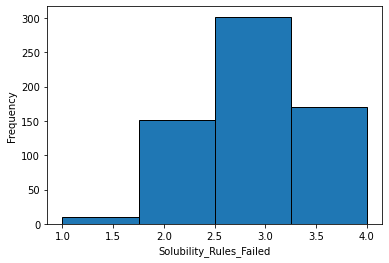

In [30]:
plt.hist(pepfunn_review['Solubility_Rules_Failed'],bins=4, edgecolor='black')
plt.xlabel('Solubility_Rules_Failed')
plt.ylabel('Frequency')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

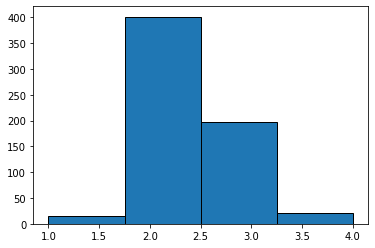

In [28]:
plt.hist(pepfunn_review['Synthesis_Rules_Failed'],bins=4, edgecolor='black')
plt.show

In [25]:
analyzed_seqs_path = '../data/processed/sequences_reviewed.csv'
pepfunn_review.to_csv(analyzed_seqs_path)